In [257]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from torch import utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [415]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=64, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [424]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [693]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [236]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.f_action = f
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._rho_loss_opt = None
        self._loss = None
        self._l1_loss = None
        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)# развернули в вектор ( 784 столбца, значения и 1 столбец)
        h = self.E(x) # вызов энкодера с активацией
        self.data_rho = h.mean(dim=0)# усредненние нейрона сквозь батч (по столбцам)
        out = self.D(h) # раскодирование данных
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl_opt = - self.data_rho*np.log(rho)-(1-self.data_rho)*np.log(1-rho)
        if size_average:
            self._rho_loss_opt = dkl_opt.mean()
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss_opt = dkl_opt.sum()
            self._rho_loss = dkl.sum()
        return self._rho_loss ,self._rho_loss_opt
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)# нюанс, в отличие от предыдцщих функций ошибок, 
        #мы тут дополнительно преобразовываем таргет, так как таргет является самим пикселем (1х784)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
    
    def l1_loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._l1_loss = F.l1_loss(x, target)
        return self._l1_loss

In [171]:
def train(epoch, model):
    train_size = len(train_loader.sampler)
    #report=''
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        rho_loss = model.rho_loss(rho)
        loss = model.loss(output, data) + rho_loss[0]# rho_loss[0] - оригинальная функция, rho_loss[1] -оптимизированная 
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            print("Эпоха:",epoch,'Ошибка:',float(loss), '\tRho:', (float(rho_loss[0]),float(rho_loss[1])))
            
            

In [677]:
def train_l1(epoch, model): # функция, где прибавляется l1 loss
    train_size = len(train_loader.sampler)
    
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        l1_loss = model.l1_loss(output,data)
        loss = model.loss(output, data) + l1_loss
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            print("Эпоха:",epoch,'Ошибка:',float(loss), '\tL1:', (float(l1_loss)))

In [678]:
def test_own(epoch,model,opt_loss='rho'):
    global test_loss, test_rho, test_rho_opt , test_loss2, test_l1_loss
    loss=0
    loss_rho=0
    loss_rho_opt=0
    l1_loss=0
    with torch.no_grad():
        for data, _ in test_loader:
            output = model(data)
            loss+= model.loss(output, data, size_average=False).item() # sum up batch loss
            loss_rho+=model.rho_loss(rho, size_average=False)[0]
            loss_rho_opt+=model.rho_loss(rho, size_average=False)[1]
            l1_loss+=model.l1_loss(output,data)
    test_loss.append(loss/(784*len(test_loader.dataset)))
    test_rho.append(loss_rho/(len(test_loader.dataset)*model.latent_size))
    test_rho_opt.append(loss_rho_opt/(len(test_loader.dataset)*model.latent_size))
    test_l1_loss.append(l1_loss/(len(test_loader.dataset)*model.latent_size))
    test_loss2.append(loss/(784*len(test_loader.dataset)))
    
          
    if opt_loss=='rho':
        print('\nТест Эпоха:',epoch,'Ошибка:',float(test_loss[epoch-1]),end=', ')
        print('\t Rho:', float(test_rho[epoch-1]),float(test_rho_opt[epoch-1]),'\n')
    elif opt_loss=='l1':
        print('\nТест Эпоха:',epoch,'Ошибка:',float(test_loss2[epoch-1]),end=', ')
        print('\t L1:', float(test_l1_loss[epoch-1]),'\n')
        
        

In [682]:
def plot_mnist(data,shape):
    for idt,dt in enumerate(data):
        pixels = dt[0,:,:]
     
        #pixels = np.array(pixels, dtype='uint8')

        pixels = pixels.reshape((28, 28))
      
        plt.subplot(shape[1],shape[0],idt+1)
        
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.rcParams["axes.edgecolor"] = "green"
        plt.rcParams["axes.linewidth"] = 2
        plt.imshow(pixels, cmap = plt.cm.binary,interpolation='nearest')
    plt.rcParams["figure.figsize"] = [15,8]
    plt.show()

In [694]:
%%time
# Sigm + rho_loss
test_loss=[]
test_rho=[]
test_rho_opt=[]

model=Net(64)
rho=0.05
for ep in range(1,21):
    train(ep,model)
    test_own(ep,model,opt_loss='rho')

Эпоха: 1 Ошибка: 1.5076004266738892 	Rho: (0.4954087436199188, 1.4923537969589233)
Эпоха: 1 Ошибка: 0.7886931300163269 	Rho: (0.06578489392995834, 0.4889569878578186)
Эпоха: 1 Ошибка: 0.5931699275970459 	Rho: (0.12709222733974457, 0.6825365424156189)
Эпоха: 1 Ошибка: 0.47511258721351624 	Rho: (0.1206786036491394, 0.6677167415618896)

Тест Эпоха: 1 Ошибка: 0.3227235032062141, 	 Rho: 0.0016973798628896475 0.010050041601061821 

Эпоха: 2 Ошибка: 0.41970309615135193 	Rho: (0.10918910056352615, 0.6423133015632629)
Эпоха: 2 Ошибка: 0.39348748326301575 	Rho: (0.09527776390314102, 0.6121776700019836)
Эпоха: 2 Ошибка: 0.3513474464416504 	Rho: (0.0883534848690033, 0.591478705406189)
Эпоха: 2 Ошибка: 0.336490273475647 	Rho: (0.08001048862934113, 0.5740376710891724)

Тест Эпоха: 2 Ошибка: 0.22770588210748166, 	 Rho: 0.001263011828996241 0.008837583474814892 

Эпоха: 3 Ошибка: 0.31350040435791016 	Rho: (0.07213326543569565, 0.5470757484436035)
Эпоха: 3 Ошибка: 0.29453590512275696 	Rho: (0.071442604


Тест Эпоха: 19 Ошибка: 0.08113915713563258, 	 Rho: 0.0002783120726235211 0.004841161891818047 

Эпоха: 20 Ошибка: 0.08771958202123642 	Rho: (0.01145714707672596, 0.30423498153686523)
Эпоха: 20 Ошибка: 0.10117115825414658 	Rho: (0.010798955336213112, 0.30100834369659424)
Эпоха: 20 Ошибка: 0.0926440879702568 	Rho: (0.013878388330340385, 0.3104632496833801)
Эпоха: 20 Ошибка: 0.09200075268745422 	Rho: (0.011043034493923187, 0.3017416298389435)

Тест Эпоха: 20 Ошибка: 0.07965135876402563, 	 Rho: 0.0002722288481891155 0.004804289899766445 

CPU times: user 45min 44s, sys: 6min 1s, total: 51min 46s
Wall time: 3min 35s


In [681]:
%%time
# tanh + L1
test_loss2=[]
test_l1_loss=[]

model2=Net(64)
for ep in range(1,21):
    train_l1(ep,model2)
    test_own(ep,model2,opt_loss='l1')

Эпоха: 1 Ошибка: 1.9539754390716553 	L1: 0.9579256772994995
Эпоха: 1 Ошибка: 0.7185244560241699 	L1: 0.4101634621620178
Эпоха: 1 Ошибка: 0.6160964965820312 	L1: 0.33120307326316833
Эпоха: 1 Ошибка: 0.5689235925674438 	L1: 0.300568163394928

Тест Эпоха: 1 Ошибка: 0.25800244305669046, 	 L1: 7.04520134604536e-05 

Эпоха: 2 Ошибка: 0.5489832758903503 	L1: 0.28771674633026123
Эпоха: 2 Ошибка: 0.5180277228355408 	L1: 0.2719316780567169
Эпоха: 2 Ошибка: 0.5131490230560303 	L1: 0.26951804757118225
Эпоха: 2 Ошибка: 0.4865807890892029 	L1: 0.2588454782962799

Тест Эпоха: 2 Ошибка: 0.2067902339390346, 	 L1: 5.934597720624879e-05 

Эпоха: 3 Ошибка: 0.4606494903564453 	L1: 0.24793057143688202
Эпоха: 3 Ошибка: 0.4323342442512512 	L1: 0.23465663194656372
Эпоха: 3 Ошибка: 0.4096519351005554 	L1: 0.22408831119537354
Эпоха: 3 Ошибка: 0.4046844244003296 	L1: 0.221251979470253

Тест Эпоха: 3 Ошибка: 0.16332190576670122, 	 L1: 5.023765697842464e-05 

Эпоха: 4 Ошибка: 0.3465489149093628 	L1: 0.1949874758720

torch.Size([64, 784])
(64, 1, 28, 28)


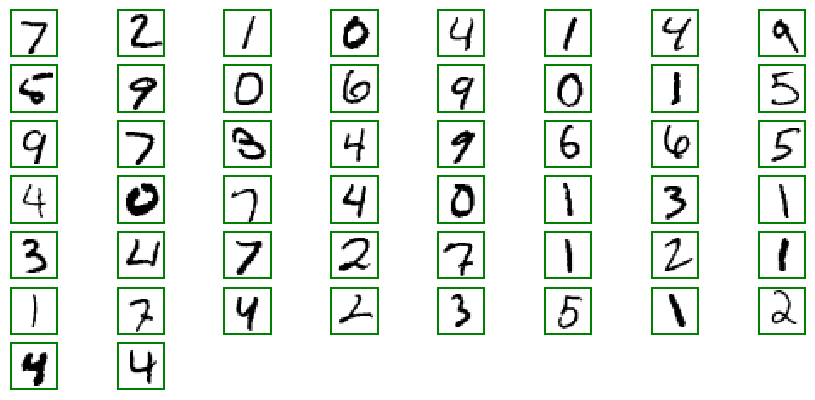

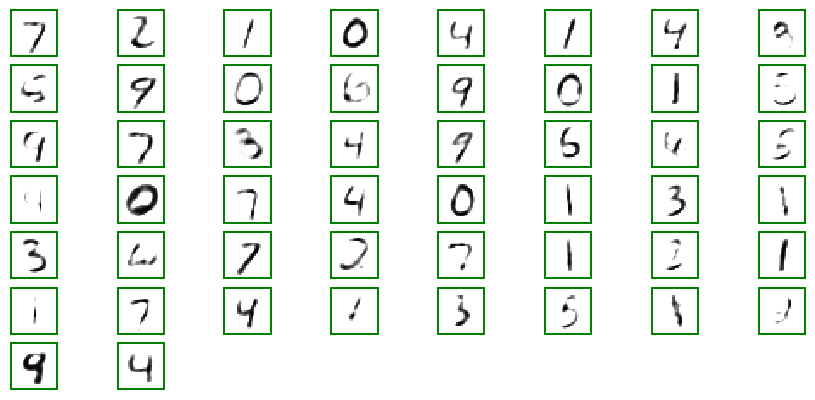

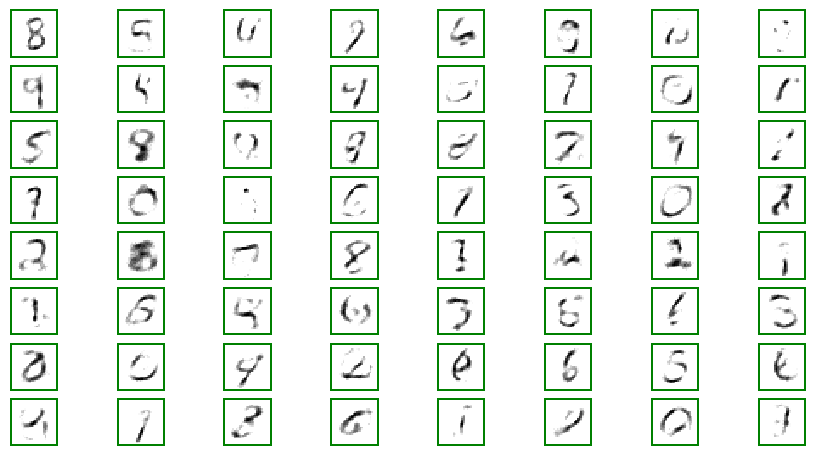

In [695]:
# Отрисовка для модели сигмоида и KL

output_to_plot=output.view(-1,1,28,28).clamp(0,1).data.numpy() # преобразование для подачи в отрисовку
decoded = model.decode(torch.eye(64))# подаем на латентный слой единичную матрицу
print(decoded.shape)
dec_to_plot = ((decoded.view(-1, 1, 28, 28))).clamp(0, 1).data.numpy()
#(decoded.view(-1, 1, 28, 28)+1)*0.5) данное преобразование переводит из 1x784 в 1(картинка)x1(канал)x28(длина)x28(ширина) 
print(dec_to_plot.shape)
plot_mnist(data,(8,8))
plot_mnist(output_to_plot,(8,8))
plot_mnist(dec_to_plot,(8,8))

torch.Size([64, 784])
(64, 1, 28, 28)


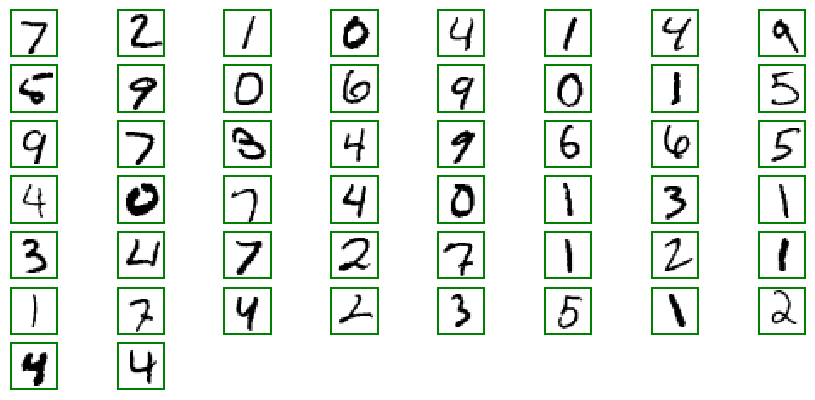

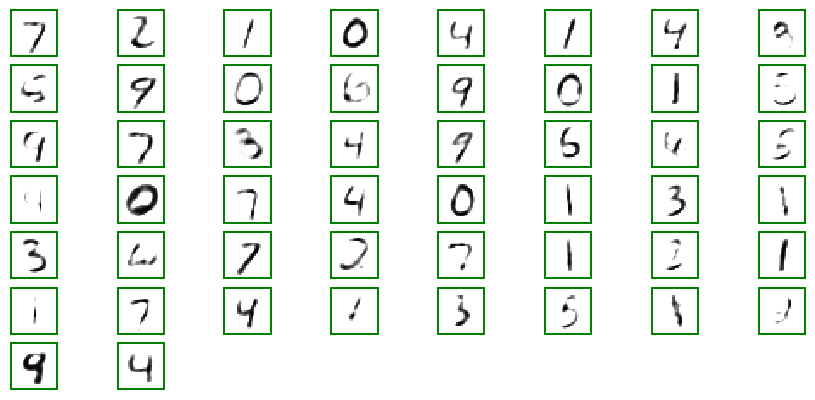

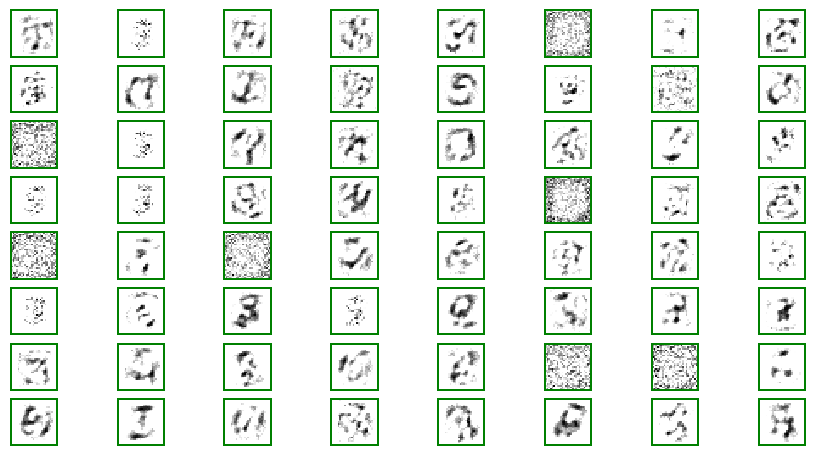

In [691]:
# Отрисовка для модели тангенса и L1

output_to_plot=output.view(-1,1,28,28).clamp(0,1).data.numpy() # преобразование для подачи в отрисовку
decoded = model2.decode(torch.eye(64))# подаем на латентный слой единичную матрицу
print(decoded.shape)
dec_to_plot = ((decoded.view(-1, 1, 28, 28))).clamp(0, 1).data.numpy()
#(decoded.view(-1, 1, 28, 28)+1)*0.5) данное преобразование переводит из 1x784 в 1(картинка)x1(канал)x28(длина)x28(ширина) 
print(dec_to_plot.shape)

plot_mnist(data,(8,8))
plot_mnist(output_to_plot,(8,8))
plot_mnist(dec_to_plot,(8,8))

Третья часть задания

In [696]:
w, _=next(iter(test_loader))
w.shape

torch.Size([64, 1, 28, 28])

In [697]:
w = nn.Parameter(w)
w_optim = optim.Adam(params=[w], lr=1e-2)

In [698]:
t=model.E(w.view(-1,28*28))
t.shape #Все картинки закодированы как 1 х 64

torch.Size([64, 64])

In [ ]:
for i in range(10000):
    w_optim.zero_grad()
    t=model.E(w.view(-1,28*28))
    loss=F.mse_loss(t,torch.eye(64))
    if i%500==0:
        print(loss)
    loss.backward()
    w_optim.step()        

In [701]:
model.E(w.view(-1,28*28))

tensor([[ 9.9896e-01,  1.5683e-04,  4.2837e-04,  ...,  7.7348e-06,
          1.8573e-04,  1.5816e-04],
        [ 2.7818e-04,  9.9907e-01,  7.3133e-05,  ...,  1.5110e-05,
          4.0339e-04,  2.9922e-04],
        [ 6.8355e-05,  2.6053e-05,  9.9912e-01,  ...,  2.8712e-05,
          3.7910e-04,  2.1833e-04],
        ...,
        [ 2.3793e-07,  1.2005e-06,  3.9325e-06,  ...,  9.9924e-01,
          2.7631e-04,  1.4611e-05],
        [ 8.2853e-06,  2.8272e-04,  3.4941e-04,  ...,  1.8900e-04,
          9.9915e-01,  1.9150e-05],
        [ 5.8139e-05,  3.6397e-04,  1.2900e-04,  ...,  7.4046e-05,
          1.1200e-05,  9.9911e-01]])

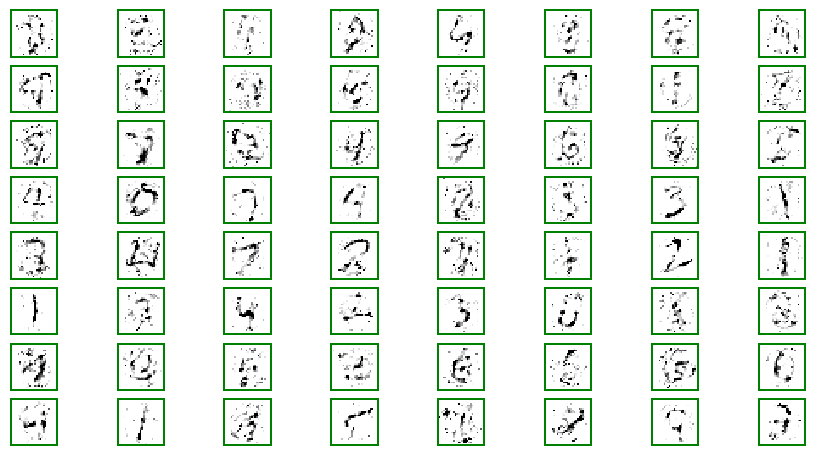

In [700]:
plot_mnist(w.clamp(0,1).data.numpy(),(8,8))